## README

I followed the attached link to learn how pytorch neural nets work and and how to create a playing card classifier.
Note: Python 3.12 didn't work, try downgrading if so.

https://www.youtube.com/watch?v=tHL5STNJKag

In [3]:
!pip3 install torch torchvision timm matplotlib pandas numpy tqdm ipywidgets

Looking in indexes: https://pypi.org/simple, https://pypi.ngc.nvidia.com


In [4]:
import torch
import torch.nn as nn # provides neural network functions like convolution layers
import torch.optim as optim # provides optimizer
from torch.utils.data import Dataset, DataLoader
import torchvision # helps working with images easier
import torchvision.transforms as transforms 
from torchvision.datasets import ImageFolder
import timm # pytorch image model library, pretrained weights optimized for image classification

import matplotlib.pyplot as plt # data visualization
import pandas as pd
import numpy as np
import sys
from tqdm import tqdm # for progress bar
import os
from PIL import Image
import random



train = True # determine if want to train new model or use exists
have_data = False # set to false if dont have any data

input_image_height = 128
input_image_width = 128

In [6]:
# Check that MPS is available, Optimize performance on Apple Silicon Processors

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

if not torch.backends.mps.is_available():
    if not torch.backends.mps.is_built():
        print("MPS not available because the current PyTorch install was not "
              "built with MPS enabled.")
    else:
        print("MPS not available because the current MacOS version is not 12.3+ "
              "and/or you do not have an MPS-enabled device on this machine.")

else:
    device = torch.device("mps")
    print("Selected device", device)

Selected device mps


## STEP 1: Set up data set and date loader

In [12]:
# Generate synthethic images

def log2img(class_name):
    pixel_data = []
    found_start = False
    log_path = f"logdata/{class_name}.log"
    with open(log_path, 'r', encoding='utf-8', errors='ignore') as file:
        for line in file:
            # skip straight to the data
            if not found_start:
                if "index: 0" in line:
                    found_start = True
                continue
            else:
                if "AI" in line:
                    break
                parts = line.split(',')
                for part in parts:
                    if 'data:' in part:
                        # Extract the hex after 'data:'
                        word = part.split(': ')[1].strip().zfill(8)
                        # word = [R1, G1, B1, R0, G0, B0]
                        int_val = int(word, 16)  # Convert hexadecimal string to integer

                        # Extract individual R, G, and B components
                        R0 = ((int_val >> 27) & 0b11111) << 3
                        G0 = ((int_val >> 21) & 0b111111) << 2
                        B0 = ((int_val >> 16) & 0b11111) << 3
                        R1 = ((int_val >> 11) & 0b11111) << 3
                        G1 = ((int_val >> 5) & 0b111111) << 2
                        B1 = (int_val & 0b11111) << 3

                        # NOTE: reorder these RGB values to see which best fits the ml model and camera output
                        p0 = [G0, B0, R0]
                        p1 = [G1, B1, R1]
                        
                        pixel_data.append(p1)
                        pixel_data.append(p0)
        
            height = 128
            width = 128

            data = np.array(pixel_data)
            target_shape = (height, width, 3)

            image_data = np.zeros((height * width, 3), dtype=np.uint8)
            image_data[:len(data)] = data
            image_data = image_data.reshape(target_shape)
            image = Image.fromarray(image_data)
        return image

def random_rotate_180(img):
    return img.rotate(180) if random.random() < 0.5 else img

# transform applied to all images
transform = transforms.Compose([
    transforms.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2, hue=0.1),
    transforms.RandomPerspective(distortion_scale=0.25, p=0.2),
    transforms.Lambda(random_rotate_180), # handle card orientation
    transforms.RandomRotation(degrees=(-8,8)), # to handle camera rotation
    transforms.RandomGrayscale(p=0.2),
    transforms.ToTensor()
])

# creates all the datasets for a specific class_name
def create_class_dataset(class_name):
    image = log2img(class_name)
    dataset_size = 50 # number of images per folder
    dataset_folders = ["train", "valid", "test"]

    for folder in dataset_folders:
        # make dir if doenst eist
        image_dir = f"dataset/{folder}/{class_name}"
        os.makedirs(image_dir, exist_ok=True)
        if folder == "train":
            # save og image into training set
            image.save(os.path.join(image_dir, f"{class_name}-0.jpg"))

        # create and save syntehtic images
        for i in range(1, dataset_size):
            synthetic_image = transform(image)
            synthetic_image_pil = transforms.ToPILImage()(synthetic_image)
            synthetic_image_pil.save(os.path.join(image_dir, f"{class_name}-{i}.jpg"))


In [14]:
# Create all data sets by iterating througho the log_data
if have_data == False:
    for log in os.listdir("logdata"):
        class_name = os.path.splitext(log)[0]
        create_class_dataset(class_name)

In [15]:
class PlayingCardDataset(Dataset):
    def __init__(self, data_dir, transform=None):
        self.data = ImageFolder(data_dir, transform=transform) # Creates classes using folder name
    
    def __len__(self):
        return len(self.data)
    
    def __getitem__(self, idx):
        return self.data[idx]
    
    @property
    def classes(self):
        return self.data.classes

# transform input images
transform = transforms.Compose([
    transforms.Resize((input_image_height, input_image_width)), # resize input image to desired pixel dimensions
    transforms.ToTensor(), # converts pixel RGB val from [0,255] -> [0,1]
])

train_dir = "dataset/train"
valid_dir = "dataset/valid"
test_dir = "dataset/test"

train_dataset = PlayingCardDataset(train_dir, transform)
valid_dataset = PlayingCardDataset(valid_dir, transform)
test_dataset = PlayingCardDataset(test_dir, transform)

# Data loading
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
val_loader = DataLoader(valid_dataset, batch_size=32, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)


In [16]:
## STEP 2: Design Neural Network

In [17]:
# Test ml model dimensions for non square image

conv1 = nn.Conv2d(in_channels=3, out_channels=6, kernel_size=5, stride=2, padding=0) # 3 = input channels (RGB), 64 = output channel = depth of array
max_pool1 = nn.MaxPool2d(kernel_size=2, stride = 2)
conv2 = nn.Conv2d(in_channels=6, out_channels=16, kernel_size=4, stride=1, padding=0)
max_pool2 = nn.MaxPool2d(kernel_size=2, stride = 2)
flatten = nn.Flatten()

input = torch.rand(3, input_image_height, input_image_width)
print(f"input: {input.shape}")
input = conv1(input)
print(f"conv1 -> {input.shape}")
input = max_pool1(input)
print(f"max_poo1 -> {input.shape}")
input = conv2(input)
print(f"conv2 -> {input.shape}")
input = max_pool2(input)
print(f"max_pool2 -> {input.shape}")
input = flatten(input)
print(f"flatten-> {input.shape}")


input: torch.Size([3, 128, 128])
conv1 -> torch.Size([6, 62, 62])
max_poo1 -> torch.Size([6, 31, 31])
conv2 -> torch.Size([16, 28, 28])
max_pool2 -> torch.Size([16, 14, 14])
flatten-> torch.Size([16, 196])


In [18]:
class CardClassifierCNN(nn.Module):
    def __init__(self, num_classes=54):
        super(CardClassifierCNN, self).__init__()

        # convolution layer output size = (input_image_size - kernel_size + 2*padding)/stride + 1
        self.conv1 = nn.Conv2d(in_channels=3, out_channels=6, kernel_size=5, stride=2, padding=0) # 3 = input channels (RGB), 64 = output channel = depth of array
        self.relu1 = nn.ReLU() # add non linearity using reLU activation function (doesnt change size)
        self.max_pool1 = nn.MaxPool2d(kernel_size=2, stride = 2) # pooling layer reduces image by factor of 2

        self.conv2 = nn.Conv2d(in_channels=6, out_channels=16, kernel_size=4, stride=1, padding=0) # 6 = out_channel of prev conv layer
        self.relu2 = nn.ReLU()
        self.max_pool2 = nn.MaxPool2d(kernel_size=2, stride = 2) # pooling layer reduces image by factor of 2

        # flatten 3d convolution layer's tensor into 1d tensor
        self.flatten = nn.Flatten()

        # transition convolutino layer into fully connected layers
        self.fc3 = nn.Linear(16*14*14, 120) # 16 = out_channel of final conv layer, 14 * 14 image,  120 = desired layer size
        self.relu3 = nn.ReLU()
        self.fc4 = nn.Linear(120, num_classes)
        

     # define order of the layers
    def forward(self,x):
        x = self.conv1(x)
        x = self.relu1(x)
        x = self.max_pool1(x)

        x = self.conv2(x)
        x = self.relu2(x)
        x = self.max_pool2(x)

        x = self.flatten(x)

        x = self.fc3(x)
        x = self.relu3(x)

        x = self.fc4(x)

        # softmax already impleneted into cross entropy loss function 
     
        return x


## STEP 2: Train + Validate

In [19]:
# Note: want to validate the model on data it hasn't been trained on => split data into train and valid dataset.
# Terms: Epoch = one run through entire training dataset, step = one batch of data

# general idea: Load data in model in batches, then calculate loss and perform backpropagation to modify weights starting from last layer to minimize that loss

# training parameters
num_epochs = 15
train_losses, val_losses = [], []
model = CardClassifierCNN()
print(model)
model.to(device) # utilize processor
criterion = nn.CrossEntropyLoss() # loss function (what model optimizes to minimize loss)
optimizer = optim.Adam(model.parameters(), lr=0.001)

CardClassifierCNN(
  (conv1): Conv2d(3, 6, kernel_size=(5, 5), stride=(2, 2))
  (relu1): ReLU()
  (max_pool1): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv2): Conv2d(6, 16, kernel_size=(4, 4), stride=(1, 1))
  (relu2): ReLU()
  (max_pool2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (flatten): Flatten(start_dim=1, end_dim=-1)
  (fc3): Linear(in_features=3136, out_features=120, bias=True)
  (relu3): ReLU()
  (fc4): Linear(in_features=120, out_features=54, bias=True)
)


In [20]:
if train:
    for epoch in range(num_epochs):
        # Training phase
        model.train()
        running_loss = 0.0
        for images, labels in tqdm(train_loader, desc='Training loop'):
            images, labels = images.to(device), labels.to(device)    
            
            #forward pass
            outputs = model(images) # call forward on the images
            loss = criterion(outputs, labels)

            # backward pass
            optimizer.zero_grad()
            loss.backward() # backpropagation to update model weight
            optimizer.step()
            
            running_loss += loss.item() * labels.size(0)
        train_loss = running_loss / len(train_loader.dataset)
        train_losses.append(train_loss)
        
        # Validation phase
        model.eval()
        running_loss = 0.0
        with torch.no_grad():
            for images, labels in tqdm(val_loader, desc='Validation loop'):
                images, labels = images.to(device), labels.to(device)
                outputs = model(images)
                loss = criterion(outputs, labels)
                running_loss += loss.item() * labels.size(0)
        val_loss = running_loss / len(val_loader.dataset)
        val_losses.append(val_loss)
        print(f"Epoch {epoch+1}/{num_epochs} - Train loss: {train_loss}, Validation loss: {val_loss}")
else: # load in already trained model
    # model = timm.create_model('efficientnet_b0', pretrained=False)  # define architetcture of model
    model_weights_path = "model.pth"
    model.load_state_dict(torch.load(model_weights_path))
    model.eval() # set to eval mode

Training loop:   0%|          | 0/85 [00:00<?, ?it/s]

Validation loop: 100%|██████████| 83/83 [00:02<00:00, 38.20it/s]


Epoch 1/15 - Train loss: 3.7988517732973452, Validation loss: 3.259868232571349


Validation loop: 100%|██████████| 83/83 [00:01<00:00, 42.43it/s]


Epoch 2/15 - Train loss: 2.015753260453542, Validation loss: 1.0173757722093044


Validation loop: 100%|██████████| 83/83 [00:01<00:00, 42.24it/s]


Epoch 3/15 - Train loss: 0.6593830137782627, Validation loss: 0.5176349609121624


Validation loop: 100%|██████████| 83/83 [00:02<00:00, 41.38it/s]


Epoch 4/15 - Train loss: 0.33632374436767015, Validation loss: 0.3426472068182105


Validation loop: 100%|██████████| 83/83 [00:02<00:00, 39.58it/s]


Epoch 5/15 - Train loss: 0.20741520082509077, Validation loss: 0.3403611800753746


Validation loop: 100%|██████████| 83/83 [00:02<00:00, 37.78it/s]


Epoch 6/15 - Train loss: 0.1445811082036407, Validation loss: 0.2533741829971743


Validation loop: 100%|██████████| 83/83 [00:01<00:00, 41.67it/s]


Epoch 7/15 - Train loss: 0.08784985820452372, Validation loss: 0.2927056051613319


Validation loop: 100%|██████████| 83/83 [00:01<00:00, 44.06it/s]


Epoch 8/15 - Train loss: 0.0722415761594419, Validation loss: 0.24090782021054785


Validation loop: 100%|██████████| 83/83 [00:01<00:00, 43.91it/s]


Epoch 9/15 - Train loss: 0.05319497676083335, Validation loss: 0.21037034182129985


Validation loop: 100%|██████████| 83/83 [00:01<00:00, 42.94it/s]


Epoch 10/15 - Train loss: 0.03336366867163667, Validation loss: 0.23612555041022243


Validation loop: 100%|██████████| 83/83 [00:01<00:00, 41.90it/s]


Epoch 11/15 - Train loss: 0.02024238514403502, Validation loss: 0.21244604964701858


Validation loop: 100%|██████████| 83/83 [00:02<00:00, 40.91it/s]


Epoch 12/15 - Train loss: 0.01670324050993831, Validation loss: 0.2117767292440912


Validation loop: 100%|██████████| 83/83 [00:01<00:00, 42.89it/s]


Epoch 13/15 - Train loss: 0.013680238649249077, Validation loss: 0.20214031630027435


Validation loop: 100%|██████████| 83/83 [00:01<00:00, 42.22it/s]


Epoch 14/15 - Train loss: 0.006757694030508261, Validation loss: 0.20015449580195827


Validation loop: 100%|██████████| 83/83 [00:02<00:00, 40.54it/s]

Epoch 15/15 - Train loss: 0.004216544801990191, Validation loss: 0.20767913870611993


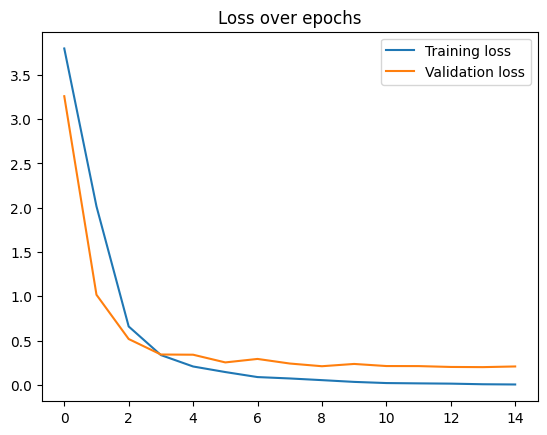

In [21]:
# Visualize Loss

plt.plot(train_losses, label='Training loss')
plt.plot(val_losses, label='Validation loss')
plt.legend()
plt.title("Loss over epochs")
plt.show()

## Assessing the model

In [22]:
# Load and preprocess the image

transform = transforms.Compose([
    transforms.Resize((input_image_height, input_image_width)), # resize input image to desired pixel dimensions
    transforms.ToTensor(), # converts pixel RGB val from [0,255] -> [0,1]
])

def preprocess_image(image_path, transform):
    image = Image.open(image_path).convert("RGB")
    return image, transform(image).unsqueeze(0)

# Predict using the model
def predict(model, image_tensor):
    model.eval()
    with torch.no_grad():
        image_tensor = image_tensor.to(device)
        outputs = model(image_tensor)
        probabilities = torch.nn.functional.softmax(outputs, dim=1)
        probabilities = probabilities.cpu().numpy().flatten()
        max_idx = np.argmax(probabilities)
        predicted_class = train_dataset.classes[max_idx]
    return predicted_class, probabilities

# Visualization
def visualize_predictions(original_image, predicted_class, probabilities, class_names):
    fig, axarr = plt.subplots(1, 2, figsize=(14, 7))
    
    # Display image
    axarr[0].imshow(original_image)
    axarr[0].axis("off")
    axarr[0].set_title(f"Prediction: {predicted_class}")
    
    # Display predictions
    axarr[1].barh(class_names, probabilities)
    axarr[1].set_xlabel("Probability")
    axarr[1].set_title("Class Predictions")
    axarr[1].set_xlim(0, 1)

    plt.tight_layout()
    plt.show()

In [23]:
# Get accuracy using test data
label_to_class = {v: k for k, v in ImageFolder(test_dir).class_to_idx.items()}

sample_size = 100
num_test_images = 0
num_correct = 0
random_idxes = random.sample(range(0, len(test_dataset)), sample_size)

for i in range(sample_size):
    if num_test_images == sample_size:
        break
    random_idx = random_idxes[i]
    image, label = test_dataset[random_idx]
    image_tensor = image.unsqueeze(0) # makes it a batch size of 1 when model expects a batch of inages as input
    predicted_class, probabilities = predict(model, image_tensor)
    num_test_images += 1
    if predicted_class == label_to_class[label]:
        num_correct += 1
    else: # display if incorrect
        original_image = transforms.ToPILImage()(image)
        # visualize_predictions(original_image, predicted_class, probabilities, class_names)

    class_names = train_dataset.classes
print(f"Accuracy: {num_correct} / {sample_size} Correct ({100 * num_correct / sample_size}%)")

Accuracy: 98 / 100 Correct (98.0%)


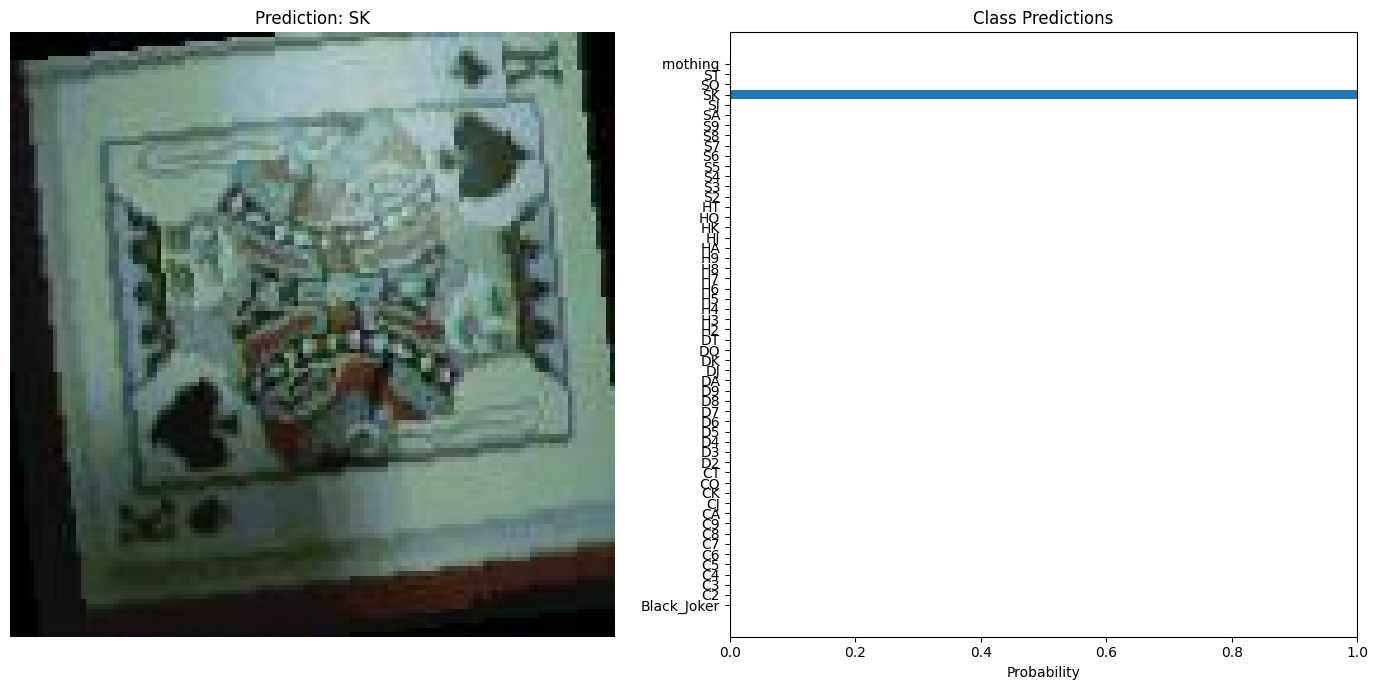

In [24]:
from glob import glob
test_images = glob("dataset/test/*/*")
test_examples = np.random.choice(test_images, 1)

for example in test_examples:
    original_image, image_tensor = preprocess_image(example, transform)
    predicted_class, probabilities = predict(model, image_tensor)

    class_names = train_dataset.classes 
    visualize_predictions(original_image, predicted_class, probabilities, class_names)

# manual test

def preprocess_user_image(image_path, transform):
    image = Image.open(image_path).convert("RGB")
    # image = image.rotate(90) # must be sideways
    return image, transform(image).unsqueeze(0)

# user_image_name = "DA-2.jpg"
# user_image_path = f"dataset/usertest/{user_image_name}"
# original_image, image_tensor = preprocess_image(user_image_path, transform)
# print(image_tensor.shape)
# predicted_class, probabilities = predict(model, image_tensor)

# # Assuming dataset.classes gives the class names
# class_names = train_dataset.classes 
# visualize_predictions(original_image, predicted_class, probabilities, class_names)



## Step 3: Save the state_dict of the model as a pth

In [26]:
# save .pth (trained weighted sums)
if train:
    model_path = "model.pth"
    model.eval()
    torch.save(model.state_dict(), model_path)

## Step 4: To use on STM32, convert to tflite model and quantize

In [37]:
!pip3 install nvidia-pyindex 
!pip3 install onnx_graphsurgeon onnx2tf sng4onnx onnxsim tensorflow==2.15

Looking in indexes: https://pypi.org/simple, https://pypi.ngc.nvidia.com
Looking in indexes: https://pypi.org/simple, https://pypi.ngc.nvidia.com


In [27]:
import tensorflow as tf
import torch
import onnx2tf

input_shape = (1, 3, input_image_height, input_image_width)

# Step 1: Convert PyTorch model to ONNX
dummy_input = torch.randn(input_shape)  # Example input tensor
model_cpu = model
model_cpu.to('cpu')
torch.onnx.export(model_cpu, dummy_input, "model.onnx", export_params=True)

In [28]:
# Step 2:Convert ONNX -> TF
!onnx2tf -i model.onnx -b 1 -osd -cotof


Model optimizing started ============================================================
Simplifying...
Finish! Here is the difference:
┏━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━┓
┃            ┃ Original Model ┃ Simplified Model ┃
┡━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━┩
│ Constant   │ 8              │ 8                │
│ Conv       │ 2              │ 2                │
│ Flatten    │ 1              │ 1                │
│ Gemm       │ 2              │ 2                │
│ MaxPool    │ 2              │ 2                │
│ Relu       │ 3              │ 3                │
│ Model Size │ 1.5MiB         │ 1.5MiB           │
└────────────┴────────────────┴──────────────────┘

Simplifying...
Finish! Here is the difference:
┏━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━┓
┃            ┃ Original Model ┃ Simplified Model ┃
┡━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━┩
│ Constant   │ 8              │ 8                │
│ Conv       │ 2              │ 2                │
│ 

In [29]:
# test tf model
import tensorflow as tf
import numpy as np
from PIL import Image

def preprocess_image(image_path):
    img = Image.open(image_path)
    img = img.resize((input_image_height, input_image_width))  # Resize the image to match model input size
    img = (np.array(img) / 255.0).astype(np.float32)  # Normalize pixel values to [0, 1], and is type float32
    img = np.expand_dims(img, axis=0)  # Add batch dimension # tf tensor = (1, 128, 128, 3)
    return img

# Test the model with an input image
def test_model_with_image(image_path, model):
    # Preprocess the image
    img = preprocess_image(image_path)
    # Perform inference
    prediction = model(img)
    return prediction

# Load tf model
model = tf.saved_model.load("saved_model")

image_name = "C8/C8-2.jpg"
image_path = f"dataset/test/{image_name}"
output_data = test_model_with_image(image_path, model)
print("Output:", output_data)

max_index = np.argmax(output_data)
label_to_class = {v: k for k, v in ImageFolder(test_dir).class_to_idx.items()}

print(f"prediction: {label_to_class[max_index]} ")


Output: tf.Tensor(
[[   0.7250249  -69.239235   -59.000782   -54.13053    -23.543264
   -10.916425    11.79535     42.85742     -9.520354   -80.43798
   -26.519938     3.096091    10.148222    16.75954   -118.810486
   -96.087296  -145.22652    -99.32962   -104.30066    -32.76746
     2.8830202  -53.3323    -173.99602    -32.819466    -5.5916886
    -6.4592056    4.0627933 -182.99467   -107.997505  -146.71017
   -99.67371    -79.47116    -13.778769     7.3773384  -31.773357
  -153.71649    -30.123732   -26.063269    -8.417586    -2.3682694
   -59.32326    -75.26782    -36.957615   -69.19415    -44.403683
    11.168847    11.208298   -21.535769   -25.1662     -12.530623
     7.525151    -7.936352    18.809788  -160.95013  ]], shape=(1, 54), dtype=float32)
prediction: C8 


In [30]:
# convert tf -> tflite
from torch.utils.data import DataLoader, Subset

def rep_dataset():
    """Generator function to produce representative dataset for post-training quantization."""
    subset_indices = list(range(100))  # Indices of the first 100 samples
    subset = Subset(valid_dataset, subset_indices)
    # Use a few samples from the training set.
    for image_tensor, label in subset: # pytorch image tensor = (1,3, 128,128)
        image_tensor = image_tensor.unsqueeze(0) # add batch dimension
        image_tensor = image_tensor.permute(0, 2, 3, 1)  # Transpose dimensions to match tensor flow order of (1, 128, 128, 3)
        yield [tf.dtypes.cast(image_tensor, tf.float32)]


# Quantize the TF model = 8-bit linear quantization of an NN model 
converter = tf.lite.TFLiteConverter.from_saved_model("saved_model")
converter.signature_key = "serving_default"
converter.optimizations = [tf.lite.Optimize.DEFAULT] # st might've warned not to use this. try commneting out if dones twork
converter.representative_dataset = rep_dataset

# Ensure that if ops can't be quantized, the converter throws an error
converter.target_spec.supported_ops = [tf.lite.OpsSet.TFLITE_BUILTINS_INT8]

converter.inference_input_type = tf.float32 # note: uint8 is far too inaccuarte
converter.inference_output_type = tf.float32

# Convert TF -> TFLITE
tflite_quantized_model = converter.convert()
with open("model.tflite", "wb") as f:
    f.write(tflite_quantized_model)

Summary on the non-converted ops:
---------------------------------
 * Accepted dialects: tfl, builtin, func
 * Non-Converted Ops: 10, Total Ops 21, % non-converted = 47.62 %
 * 10 ARITH ops

- arith.constant:   10 occurrences  (f32: 8, i32: 2)



  (f32: 2)
  (f32: 2)
  (f32: 2)
  (f32: 1)
  (f32: 1)
fully_quantize: 0, inference_type: 6, input_inference_type: FLOAT32, output_inference_type: FLOAT32


In [32]:
import tensorflow as tf
from PIL import Image
import numpy as np
# test tflite model

def preprocess_image(image_path, input_details):
    img = Image.open(image_path)
    img = img.resize((input_details[0]['shape'][2], input_details[0]['shape'][1]))  # Resize image to model input shape (128, 128)
    img = (np.array(img) / 255.0).astype(np.float32)  # Normalize pixel values to [0, 1], and is type float32 # note: uint8 is far too inaccuarte
    img = np.expand_dims(img, axis=0)  # Add batch dimension
    return img

def tflite_predict(image_tensor, interpreter):    
    output_details = interpreter.get_output_details()
    interpreter.set_tensor(input_details[0]['index'], image_tensor) # Set input tensor
    # Run inference
    interpreter.invoke()
    # Get the output tensor
    probabilities = interpreter.get_tensor(output_details[0]['index'])[0]

    min_val = probabilities.min()
    max_val = probabilities.max()
    normalized_probabilities = (probabilities - min_val) / (max_val - min_val)
    max_idx = np.argmax(normalized_probabilities)
    predicted_class = train_dataset.classes[max_idx]
    
    return predicted_class, normalized_probabilities

# Load the TFLite model
interpreter = tf.lite.Interpreter(model_path="model.tflite")
interpreter.allocate_tensors()
input_details = interpreter.get_input_details()

image_name = "D9/D9-7.jpg"
image_path = f"dataset/test/{image_name}"
image_tensor = preprocess_image(image_path, input_details)
predicted_class, probabilities = tflite_predict(image_tensor, interpreter)

print("Output:", probabilities)
print(predicted_class)


Output: [0.6232558  0.12558138 0.60465115 0.48837206 0.744186   0.6976744
 0.67906976 0.64651155 0.81860465 0.7116279  0.47906974 0.53953487
 0.59999996 0.5860465  0.3860465  0.41395348 0.33023256 0.71627903
 0.5813953  0.7209302  0.7627906  1.         0.4604651  0.46976742
 0.73953485 0.5488372  0.80930233 0.         0.40930232 0.2883721
 0.6883721  0.49302322 0.52093023 0.6744186  0.9162791  0.66976744
 0.41860464 0.5674419  0.47906974 0.6883721  0.33488372 0.5023256
 0.5674419  0.80465114 0.66511625 0.7860465  0.772093   0.9023256
 0.66976744 0.5069767  0.5627907  0.76744187 0.7906977  0.30232558]
D9


In [40]:
# assess tflite model 

label_to_class = {v: k for k, v in ImageFolder(test_dir).class_to_idx.items()}

sample_size = 1000
num_test_images = 0
num_correct = 0
random_idxes = random.sample(range(0, len(test_dataset)), sample_size)
class_names = train_dataset.classes

for i in range(sample_size):
    if num_test_images == sample_size:
        break
    random_idx = random_idxes[i]
    image, label = test_dataset[random_idx]
    image_tensor = image.unsqueeze(0) # makes it a batch size of 1 when model expects a batch of inages as input
    image_tensor = image_tensor.permute(0, 2, 3, 1)  # Transpose dimensions to match tensor flow order of (1, 128, 128, 3)
    predicted_class, probabilities = tflite_predict(image_tensor, interpreter)
    num_test_images += 1
    if predicted_class == label_to_class[label]:
        num_correct += 1
    else: # display if incorrect
        original_image = transforms.ToPILImage()(image)
        # visualize_predictions(original_image, predicted_class, probabilities, class_names)

print(f"Accuracy: {num_correct} / {sample_size} Correct ({100 * num_correct / sample_size}%)")

Accuracy: 949 / 1000 Correct (94.9%)
